<a href="https://colab.research.google.com/github/HarshSonaiya/DL/blob/main/yolov1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## YOLOV1:

Yolov1 is an advancement in the object detection and classification task introduced in "You Only Look Once:Unified, Real-Time Object Detection".

Th YOLO architecture reforms the objection detection and classification task from a classification problem to a regression problem. Previous work considered objection detection problem as a classification problem as in DPM and R-CNN models where they define multiple stages.

**DPM (Deformable Parts model)**  :

DPM use a sliding window approach where the classifier is run at evenly spaced locations over the entire image, i.e it begins with a specific window size and tries to detect the objects present in the window and if an object is present then applies the classifer to classify the object and it repeats the process by increasing the window size in subsequent iterations for the entire image.

**R-CNN(Region Based CNN)**

R-CNN uses a different approach, it tries to creat bounding boxes around an object in an image and then run the classifier on the bounding boxe to classify the object and then again fed the bounding boxes to post-processing step to tighten the boundaries of the bounding boxes, eliminate duplicate detections, and rescore the boxes based on other objects in the scene.

This methods though efficient in terms of accuracy are very slow, complex and hard to optimize.

Another issue with these approaches is that they do not generalize well for other domain images like artwork.

**Yolov1 redefines the problem as a regression problem to identify the spatially separated bounding boxes and associated class probabilties using full image.**

It approaches the problem as a single stage task where you use the entire image for identifying the objects and classifying them in a single step thus the name **You Only Look Once.**

As it uses the full image it helps to encode contextual information about the class and their appearance efficiently.

# How Yolo does this ?

1. The input image is divided into SxS gid cells where only the grid with the object centre is responsible for detecting and classifying the object even if the object spans multipe grids in the image. (S=7 in the paper)

2. For every grid cell B bounding boxes are created along with a confidence score. These confidence scores reflect how confident the model is that the box contains an object and also how accurate it thinks the box is that it predicts. (B=2 in the paper)

3. Every bounding box has 5 predictions (x, y, w, h, c) where

- x and y represent the centre of the box relative to the bounds of the grid cell.

- w and h represent the width and the height of the box relative to the entire image

- c represents the confidence score

4. For every grid cell model predicts the class probabilites (C) which represents the likelihood of the object belonging to each class, independent of the bounding boxes. These class probabilities are predicted only if an object is present in the grid cell.

## Yolo Architecture and Working

 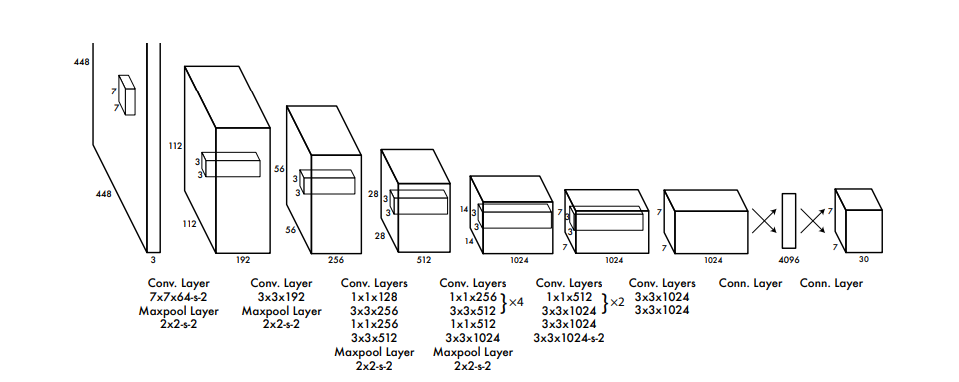

The Yolo architecture is inspired by tghe GoogleNet architecture.

The architecture consists of **24 convolution layers followed by 2 Fully connected Layers, all the layers except the last fully connected layers incorporate Leaky ReLU activation function, FC2 contains Linear activation function.**.Instead of using Inception modules which allows for the combination of multiple types of filter sizes in a single image block, enabling the network to capture features at multiple scales YOLO simply use **1 x 1 reduction layers to reduce the feature space followed by 3 x 3 convolutional layers.**

The entire architecture is pretrained on ImageNet dataset for classifying objects in 1000 classes with images of size 224 x 224.

For detection the images are rescaled to size 448 x 448 as detection requires fine-grained visual information.

The rescaled image of size 448 x 448 is divided into S x S grid with S = 7, So number of grid cells in the image = 49 with each containing 64 pixels.

Every grid cell predicts 2 Bounding Boxes along with the confidence Score and every bounding box consist of 5 prediction as disccused above.

The entire image is processed by the YOLO Architecture and produces a
**S x S x ( B x 5 + C ) tensor** as output, here **7 x 7 x ( 2 x 5 + 20) = 7 x 7 x 30.** C = 20 = number of classsification classes

**Architecture Details**

            Input                 Layers                      Output     
         
        448 x 448 x 3     Conv1 7 x 7 x 64, s=2, p=3       224 x 224 x 64
        224 x 224 x 64    MaxPool 2 x 2, s = 2             112 x 112 x 64   
        112 x 112 x 64    Conv2 3 x 3 x 192, p=1           112 x 112 x 192
        112 x 112 x 192   MaxPool 2 x 2, s = 2             56 x 56 x 192    
        56 x 56 x 192     Conv3 1 x 1 x 128                56 x 56 x 128
        56 x 56 x 128     Conv4 3 x 3 x 256, p=1           56 x 56 x 256  
        56 x 56 x 256     Conv5 1 x 1 x 256                56 x 56 x 256
        56 x 56 x 256     Conv6 3 x 3 x 512, p=1           56 x 56 x 512
        56 x 56 x 512     MaxPool 2 x 2, s = 2             28 x 28 x 512
        28 x 28 x 512     Conv7 1 x 1 x 256                28 x 28 x 256
        28 x 28 x 256     Conv8 3 x 3 x 512, p=1           28 x 28 x 512
        28 x 28 x 512     Conv9 1 x 1 x 256                28 x 28 x 256
        28 x 28 x 256     Conv10 3 x 3 x 512, p=1          28 x 28 x 512
        28 x 28 x 512     Conv11 1 x 1 x 256               28 x 28 x 256
        28 x 28 x 256     Conv12 3 x 3 x 512, p=1          28 x 28 x 512
        28 x 28 x 512     Conv13 1 x 1 x 256               28 x 28 x 256
        28 x 28 x 256     Conv14 3 x 3 x 512, p=1          28 x 28 x 512
        28 x 28 x 512     Conv15 1 x 1 x 512               28 x 28 x 512
        28 x 28 x 512     Conv16 3 x 3 x 1024, p=1         28 x 28 x 1024
        28 x 28 x 1024    MaxPool 2 x 2, s = 2             14 x 14 x 1024
        14 x 14 x 1024    Conv17 1 x 1 x 512               14 x 14 x 512
        14 x 14 x 512     Conv18 3 x 3 x 1024, p=1         14 x 14 x 1024
        14 x 14 x 1024    Conv19 1 x 1 x 512               14 x 14 x 512
        14 x 14 x 512     Conv20 3 x 3 x 1024, p=1         14 x 14 x 1024
        14 x 14 x 1024    Conv21 3 x 3 x 1024, p=1         14 x 14 x 1024
        14 x 14 x 512     Conv22 3 x 3 x 1024, s=2         7 x 7 x 1024
        7 x 7 x 1024      Conv23 3 x 3 x 1024, p=1         7 x 7 x 1024
        7 x 7 x 1024      Conv24 3 x 3 x 1024, p=1         7 x 7 x 1024
        7 x 7 x 1024      Flatten                          50176
        50176             Fc1, 1 x 4096                    4096
        4096              FC2, 1 x 1470                    1470
        1470               Reshape                         7 x 7 x 30

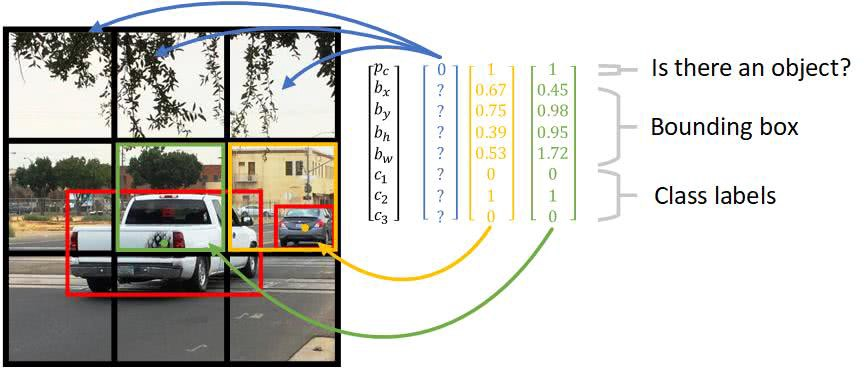

In the above image we can see that pc for every bounding box represents if it contains an object or not. If pc=0 no object is present and if pc >= 1 means there is an object present.

The values bx and by are similar to the x and y coordinates, which represent offset of the center of the object within the grid cell.

bx = (predicted_center_x - cell_top_left_x) / cell_width

by = (predicted_center_y - cell_top_left_y) / cell_height


predicted_center_x and predicted_center_y are the predicted center coordinates of the bounding box, cell_top_left_x and cell_top_left_y are the top-left coordinates of the grid cell, and cell_width and cell_height are the width and height of the grid cell, respectively.

This means that the values of bx and by represent an offset from the top-left corner of the grid cell. For example, if bx = 0.67 means the object's x coordinate is located 67% of the way across the width of the grid cell and b=0.75 means the object is 75% down from the top of the grid cell, not the absolute center of the object in the whole image.

The offsets are normalized by dividing them by the cell dimensions to ensure that they are scale-invariant.

The values bh and bq are simliar to w and h discussed above and are normalized relative to the entire image. This means that the values of w and h represent the width and height of the bounding box as a fraction of the overall image's width and height, respectively.

For example, if w = 0.39, it means that the predicted bounding box is 39% of the total image width, and if h = 0.53, the height of the bounding box is 53% of the total image height. These relative values allow the model to handle objects of various sizes and aspect ratios across the entire image, regardless of the grid cell size.

The values are also normalized by dividing them by the image dimensions to ensure that they are scale-invariant.

**Confidence score** is calculated by obtaining the probability of an object present in the image and multiplying it with the IOU value of the box.

Thus we as stated above that ** confidence scores reflect how confident the model is that the box contains an object and also how accurate it thinks the box is that it predicts**

# What is IOU Score ?

**Intersection over Union** is a metric that helps us to determine the extent of overlap between two boxes. The greater the region of overlap, the greater the IOU.

Checkout: [IOU SCORE](https://medium.com/analytics-vidhya/iou-intersection-over-union-705a39e7acef) for better understanding

# Loss function

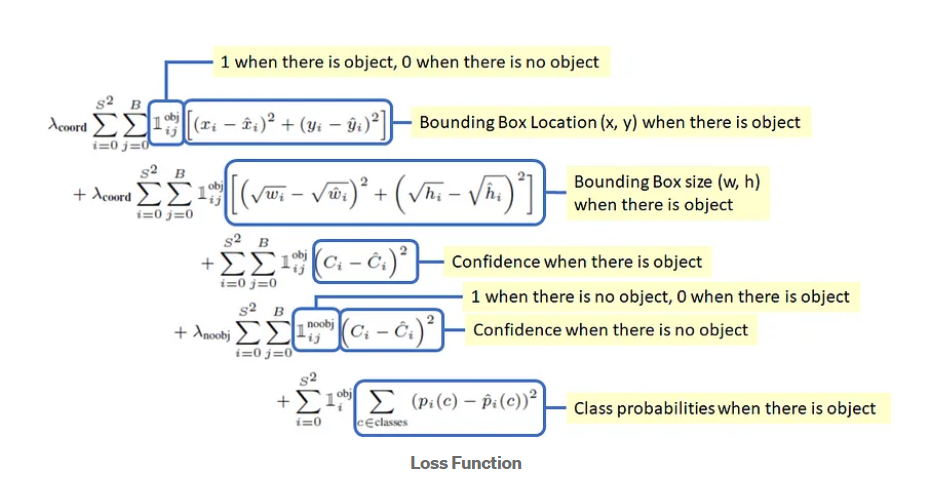

The loss function in yolo is " Sum of Square Error" instead of the traditional "MSE"

The various components of loss function are:

1. Box Loss
2. Class Loss
3. Confidence Loss

After determining the best Intersection over Union (IoU) score from the two predicted boxes, the loss for that box is calculated.

**Box Loss**

The box loss quantifies the error in the predicted bounding box parameters: center_x, center_y, width, and height.

- **Center Coordinates Loss:** This measures the error in the predicted center coordinates of the bounding box relative to the ground truth coordinates.

- **Size Loss:** This quantifies the error in the width and height of the predicted bounding box compared to the actual dimensions of the object.

- The width and height of the predicted bounding box as well as the ground truth box are square rooted to normalize the values, ensuring that the loss does not disproportionately penalize larger boxes

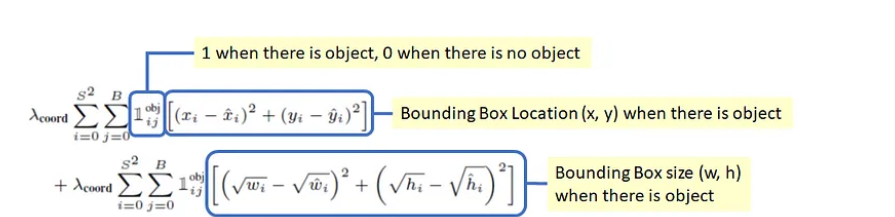


**Confidence Loss**

Confidence loss assesses how well the model predicts the object presence within the bounding boxes. It consists of two parts:

- **Object Confidence Loss:** This evaluates the confidence score for boxes that contain objects.
- **No Object Confidence Loss:** This penalizes boxes that do not contain objects.

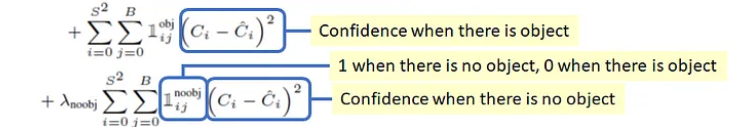


**Class Loss**

Class loss measures the accuracy of the predicted class probabilities against the true class labels.

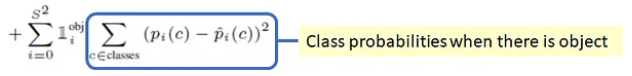

All the three losses are combined to obtain the final loss and the models target is to otpimize this loss function.

The lambda coordinates and lambda no-object are hyperparameters used to balance the influence of the different loss components on one another.

In [1]:
# Load the Pascal VOC 2007 and 2013 datasets
! wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
! wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
! wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

--2024-10-10 04:55:13--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  19.7MB/s    in 1m 40s  

2024-10-10 04:56:53 (19.1 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]

--2024-10-10 04:56:53--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[========

In [2]:
! tar xf VOCtrainval_11-May-2012.tar
! tar xf VOCtrainval_06-Nov-2007.tar
! tar xf VOCtest_06-Nov-2007.tar

In [3]:
! wget https://pjreddie.com/media/files/voc_label.py

--2024-10-10 04:59:54--  https://pjreddie.com/media/files/voc_label.py
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2042 (2.0K) [text/x-python]
Saving to: ‘voc_label.py’

voc_label.py        100%[===================>]   1.99K  --.-KB/s    in 0s      

2024-10-10 04:59:55 (576 MB/s) - ‘voc_label.py’ saved [2042/2042]



In [4]:
! python voc_label.py

In [5]:
! cat 2007_train.txt 2007_val.txt 2012_*.txt > train.txt
! cp 2007_test.txt test.txt

In [6]:
! mkdir old_txt_files
! mv 2007* 2012* old_txt_files/

In [7]:
! python generate_csv.py

In [8]:
! mkdir data
! mkdir data/images
! mkdir data/labels


In [9]:
! cp VOCdevkit/*.jpg data/images/
! cp VOCdevkit/VOC2007/labels/*.txt data/labels/
! cp VOCdevkit/VOC2012/labels/*.txt data/labels/

! mv VOCdevkit/VOC2007/JPEGImages/*.jpg data/images/
! mv VOCdevkit/VOC2012/JPEGImages/*.jpg data/images/
! mv VOCdevkit/VOC2012/labels/*.txt data/labels/
! mv VOCdevkit/VOC2007/labels/*.txt data/labels/


cp: cannot stat 'VOCdevkit/*.jpg': No such file or directory


In [10]:
! rm -rf VOCdevkit/

! mv test.txt old_txt_files/
! mv train.txt old_txt_files/

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape, Input, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras

from tensorflow.keras import backend as K
from keras.callbacks import Callback
from keras.utils import Progbar

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.model_selection import train_test_split

from PIL import Image
import cv2 as cv
import os
import shutil

In [2]:
def read(image_filename, label_filename):

    ## IMAGE
    # Construct the full path to acces the images
    images_directory = '/content/data/images/'
    image_path = os.path.join(images_directory, image_filename)

    # Open and resize the image using OpenCV
    image_matrix = cv.imread(image_path)

    # Convert this as models is trained for RGB format and OpenCV loads images
    # in BGR format
    image_matrix = cv.cvtColor(image_matrix, cv.COLOR_BGR2RGB)
    image_matrix = cv.resize(image_matrix, (448, 448))

    # normalization of each pixel according to RGB scale to smoothen the
    # learning process
    image_matrix = image_matrix / 255

    ## LABEL
    # Construct the full path
    labels_directory = '/content/data/labels/'
    label_path = os.path.join(labels_directory, label_filename)

    # Read the content of the label file, split lines, split values, and convert float
    with open(label_path, 'r') as file:
        label_content = [[float(value) for i, value in enumerate(line.split())] for line in file.read().splitlines()]

    # Initialize the label matrix to store the ground truths based on the output shape
    label_matrix = np.zeros([7, 7, 30])

    for label in label_content:

        class_ = int(label[0])

        # saves coordinate of the center points of the object
        x_center = label[1]
        y_center = label[2]
        width = label[3]
        heigth = label[4]

        # Find the grid cell the object's centre belongs to
        loc = [7 * x_center, 7 * y_center]
        loc_y = int(loc[1]) # topmost cell coordinate
        loc_x = int(loc[0]) # leftmost cell coordinate

        # coordinates of the object center relative to the grid cell
        y = loc[1] - loc_y
        x = loc[0] - loc_x

        # In label_matrix:-
        # [0:20] represent ground truth class probabilities
        # [20:24] represent x, y, w, h ground truth of object
        # [25] represent c confidence score = 1

        # check if there is another element in the same grid cell (if yes: do nothing)
        if label_matrix[loc_y, loc_x, 24] == 0:  # if true means no element is present
            label_matrix[loc_y, loc_x, class_] = 1 # class
            label_matrix[loc_y, loc_x, 20:24] = [x, y, width, heigth] # coordinates
            label_matrix[loc_y, loc_x, 24] = 1  # now an object is present in the cell

    return image_matrix, label_matrix

In [3]:
def iou(y_pred, y_truth):

  true_x_center, true_y_center, true_width, true_height = tf.unstack(y_truth, axis=-1)

  true_x1 = true_x_center - (true_width / 2)
  true_y1 = true_y_center - (true_height / 2)
  true_x2 = true_x_center + (true_width / 2)
  true_y2 = true_y_center + (true_height / 2)

  pred_x_center, pred_y_center, pred_width, pred_height = tf.unstack(y_pred, axis=-1)

  pred_x1 = pred_x_center - (pred_width / 2)
  pred_y1 = pred_y_center - (pred_height / 2)
  pred_x2 = pred_x_center + (pred_width / 2)
  pred_y2 = pred_y_center + (pred_height / 2)

  # Intersection
  inter_x1 = tf.maximum(true_x1, pred_x1)
  inter_y1 = tf.maximum(true_y1, pred_y1)
  inter_x2 = tf.minimum(true_x2, pred_x2)
  inter_y2 = tf.minimum(true_y2, pred_y2)

  inter_width = tf.maximum(inter_x2 - inter_x1, 0)
  inter_height = tf.maximum(inter_y2 - inter_y1, 0)
  intersection_area = inter_width * inter_height

  # Area of true boxes
  true_area = true_width * true_height

  # Area of predicted boxes
  pred_area = pred_width * pred_height

  # Union area
  union_area = true_area + pred_area - intersection_area

  iou_score = intersection_area / tf.maximum(union_area, 1e-6)
  return iou_score


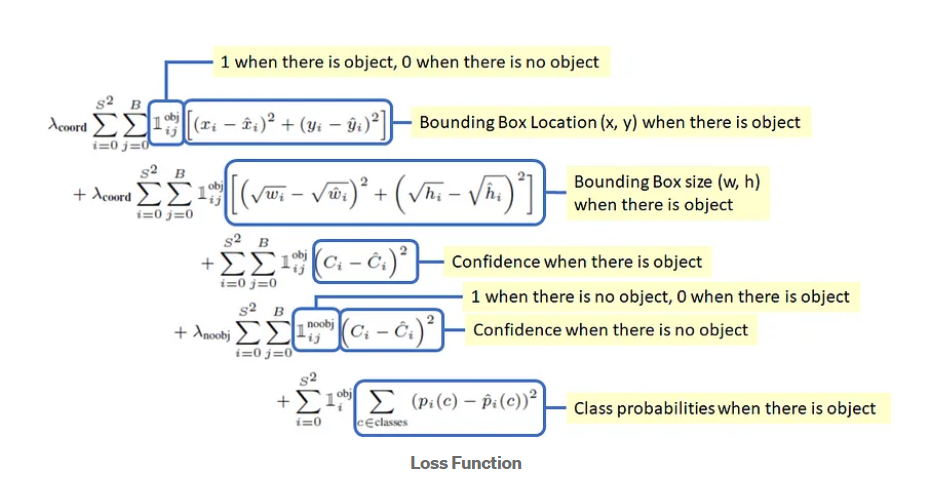

In [12]:
def yolo_loss(y_true, y_pred):

  # Extract Ground truth corodinates, class labels and confidencce scores
  class_labels = y_true[..., :20]                                        # Shape: (batch_size, 7, 7, 20)
  true_confidence_score = y_true[..., 24]                                # Shape: (batch_size, 7, 7)
  true_confidence_score = K.expand_dims(true_confidence_score, axis=-1)  # Shape: (batch_size, 7, 7, 1)
  true_box_cord = y_true[..., 20:24]                                     # Shape: (batch_size, 7, 7, 4)

  # Extract Predicted corodinates, class labels and confidencce scores
  predicted_class_prob = y_pred[..., :20]                # Shape: (batch_size, 7, 7, 20)
  predicted_confidence_scores = y_pred[..., 20:22]       # Shape: (batch_size, 7, 7, 2)
  predicted_box_cord = y_pred[..., 22:]                  # Shape: (batch_size, 7, 7, 8)

  # Reshape box co-ordinates for efficient computation
  true_box = true_box_cord
  true_box = K.reshape(true_box, (1, 7, 7, 1, 4))                     # Shape: (batch_size, 7, 7, 1, 4)
  predicted_box = predicted_box_cord
  predicted_box = K.reshape(predicted_box, (1, 7, 7, 2, 4))      # Shape: (batch_size, 7, 7, 2, 4)

  # Calculate IOU Scores
  iou_b1 = iou(true_box_cord, predicted_box_cord[..., 0, :])
  iou_b2 = iou(true_box_cord, predicted_box_cord[..., 1, :])

  # Choose the best box (with the highest IoU)
  best_box_mask = K.cast(iou_b2 > iou_b1, K.floatx())
  best_box_mask = K.expand_dims(best_box_mask, -1)

  # Combine the best bounding box predictions
  predicted_box = best_box_mask * predicted_box_cord[..., 1, :] + (1 - best_box_mask) * predicted_box_cord[..., 0, :]

  # Confidence loss
  true_confidence_score = K.expand_dims(true_confidence_score, axis=-1)                      # Shape: (batch_size, 7, 7, 1)
  predicted_confidence_best = best_box_mask * predicted_confidence_scores[..., 1] + (1 - best_box_mask) * predicted_confidence_scores[..., 0]

  object_loss = true_confidence_score * K.square(1 - predicted_confidence_best)
  no_object_loss = 0.5 * (1 - true_confidence_score) * K.square(0 - predicted_confidence_scores)

  confidence_loss = K.sum(object_loss + no_object_loss)

  # Class Loss
  class_loss = true_confidence_score * K.square(class_labels - predicted_class_prob)        # Shape: (batch_size, 7, 7, 20)
  class_loss = K.sum(class_loss)

  # Bounding box loss (x, y, w, h loss)
  true_xy = true_box_cord[..., :2]
  true_wh = true_box_cord[..., 2:]
  predicted_xy = predicted_box[..., :2]
  predicted_wh = predicted_box[..., 2:]

  box_loss = K.square(true_xy - predicted_xy) + K.square(K.sqrt(true_wh) - K.sqrt(predicted_wh))
  box_loss = 5 * K.sum(box_loss)

  # Total Loss
  total_loss = confidence_loss + class_loss + box_loss
  return total_loss

In [ ]:
model = Sequential()

#Input Layer
model.add(Input(shape=(448, 448, 3)))
# Conv. layer 1
model.add(Conv2D(filters=64, kernel_size= (7, 7), strides=(2, 2), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
# MaxPool layer 1
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

# Conv. layer 2
model.add(Conv2D(filters=192, kernel_size= (3, 3), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
# MaxPool layer 2
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

# Conv. layer 3
model.add(Conv2D(filters=128, kernel_size= (1, 1), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
# lConv. layer 4
model.add(Conv2D(filters=256, kernel_size= (3, 3), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
# Conv. layer 5
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
# Conv. layer 6
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
# MaxPool layer 3
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

# Conv. layers 7-14
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
# Conv.layer 15
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
# Conv. layer 16
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
# MaxPool layer 4
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

# Conv. layers 17-20
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))

# Conv. layer 21
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
# Conv. layer 22
model.add(Conv2D(filters=1024, kernel_size= (3, 3), strides=(2, 2), padding = 'same'))

# Conv. layer 23
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))
# Conv. layer 24
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=LeakyReLU(negative_slope=0.1)))

model.add(Flatten())

model.add(Dense(4096))
model.add(Dropout(0.5))
model.add(Dense(1470, activation='sigmoid'))
model.add(Reshape(target_shape=(7,7,30)))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=yolo_loss, optimizer=optimizer)

model.summary()


In [5]:
images_directory = '/content/data/images/'
labels_directory = '/content/data/labels/'

# Create lists of images' and labels' names
images_list = os.listdir(images_directory)
labels_list = os.listdir(labels_directory)

# Extract file names without extension (.jpeg or .txt)
images_noextension_set = set([os.path.splitext(image)[0] for image in images_list])
labels_noextension_set = set([os.path.splitext(label)[0] for label in labels_list])

# Find file names in common between the two sets
intersection_set = labels_noextension_set.intersection(images_noextension_set)

# Create two sorted lists of file names with the extensions
images_list = sorted([f"{filename}.jpg" for filename in intersection_set])
labels_list = sorted([f"{filename}.txt" for filename in intersection_set])
print('*** After ***')
print(f'Image list length: {len(images_list)}')
print(f'Label list length: {len(labels_list)}')


*** After ***
Image list length: 21503
Label list length: 21503


In [6]:
reduced_images_list = images_list[:1000]
reduced_labels_list = labels_list[:1000]

# Split Data into Training and Validation Sets
X_train, X_val, Y_train, Y_val = train_test_split(reduced_images_list, reduced_labels_list, test_size=0.2, random_state=456)

print(f'Train shape: {len(X_train)}')
print(f'Validation shape: {len(X_val)}')


Train shape: 800
Validation shape: 200


In [7]:
def load_data(images_list, labels_list):
    X = []
    Y = []
    for image, label in zip(images_list, labels_list):
        image_matrix, label_matrix = read(image, label)
        X.append(image_matrix)
        Y.append(label_matrix)
    return np.array(X), np.array(Y)



In [8]:
X_train, Y_train = load_data(X_train, Y_train)
X_val, Y_val = load_data(X_val, Y_val)

In [ ]:
yolo_trained = model.fit(
            x=X_train,
            y=Y_train,
            batch_size=1,
            epochs=50,
            validation_data=(X_val, Y_val),
            verbose=1
)


#  Summary

**YOLOv1 advantages**

1. YOLOv1 resizes images to 448 x 448 pixels, enabling it to capture fine-grained features and samples effectively.

2. It operates as a single-pass convolutional network, allowing for faster processing and real-time object detection.

3.  YOLOv1 thresholds predictions using the model's confidence scores, which helps filter out low-confidence detections and enhances overall detection accuracy.

4. The model performs data augmentation by randomly rescaling images or translating them by up to 20% of the original image dimensions, improving the robustness of the model.

5. YOLOv1 employs Non-Maximum Suppression to effectively detect objects that are present at the borders of multiple overlapping objects, reducing false positives.

**Limitations**

1.  YOLOv1 struggles to detect small objects, leading to significant localization errors, which become a primary source of inaccuracies in the model.

2. The model uses only two bounding boxes and one class per grid cell, making it challenging to predict multiple objects that may be present within a single grid cell.

3. YOLOv1 does not perform well with new or unusual aspect ratios